<a href="https://colab.research.google.com/github/carloscastillo10/predicting-academic-performance/blob/main/jul-2023/normalized-data/experiment-03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Escenario 3: Reajuste de experimentos en base al tratamiento de las clases desbalanceadas**

## Experimento 3: Reajuste de modelos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.max_columns = 50

In [ ]:
outliers = [
    'porcentaje_de_discapacidades',
    'discapacidad',
    'numero_discapacidades',
    'final_nota',
    'final_ponderado'
]

In [ ]:
def read_data():
    return pd.read_csv('data/numerical-data-with-best-predictors.csv').drop(outliers, axis = 1)

In [ ]:
numeric_data = read_data()
numeric_data['edad'] = numeric_data['edad'].replace(-1, np.nan)
mode = numeric_data['edad'].mode().values[0]
numeric_data['edad'] = numeric_data['edad'].fillna(mode)

In [ ]:
numeric_data.head()

,provincia,canton,edad,sexo,numero_reprobaciones,status,aab1_nota,aab1_ponderado,acdb1_nota,acdb1_ponderado,apeb1_nota,apeb1_ponderado,aab2_nota,aab2_ponderado,acdb2_nota,acdb2_ponderado,apeb2_nota,apeb2_ponderado,tasa_aprobacion
0,17,137,24.0,1,0,0,8.71,30.49,10.0,35.0,10.00,30.00,8.91,31.19,10.00,35.00,5.00,15.00,0.83
1,17,137,24.0,1,0,0,8.03,28.10,10.0,35.0,8.67,26.01,5.11,17.89,9.57,33.49,8.37,25.11,0.83
2,17,137,24.0,1,0,0,7.69,26.92,10.0,35.0,9.17,27.51,7.31,25.59,10.00,35.00,8.83,26.49,1.00
3,17,137,24.0,1,0,0,5.63,19.70,10.0,35.0,5.07,15.21,6.03,21.11,9.57,33.49,10.00,30.00,0.50
4,17,137,24.0,1,0,0,7.54,26.39,10.0,35.0,8.77,26.31,7.46,26.11,8.00,28.00,8.50,25.50,1.00


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Variables independientes
numeric_x = numeric_data.drop('status', axis = 1)

# Variables dependientes
numeric_y = numeric_data['status']

# Data de entrenamiento = 70%
# Data de prueba = 30%
numeric_x_train, numeric_x_test, numeric_y_train, numeric_y_test = train_test_split(numeric_x, numeric_y, test_size = 0.3, random_state = 0)

## Normalizar datos

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
numeric_x_train_scaler = scaler.fit_transform(numeric_x_train)
numeric_x_test_scaler = scaler.fit_transform(numeric_x_test)
numeric_y_train_scaler = scaler.fit_transform(numeric_y_train.values.reshape(-1, 1))
numeric_y_test_scaler = scaler.fit_transform(numeric_y_test.values.reshape(-1, 1))

## **Modelo 1: Regresión Logística**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
logistic_regresion_model = LogisticRegression(random_state = 0, class_weight = 'balanced')
logistic_regresion_model.fit(numeric_x_train_scaler, numeric_y_train)
predictions = logistic_regresion_model.predict(numeric_x_test_scaler)

In [ ]:
import statsmodels.api as sm
from scipy import stats

In [ ]:
X2 = sm.add_constant(numeric_x_train_scaler)
est = sm.OLS(numeric_y_train_scaler, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 status   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     4428.
Date:                Thu, 03 Aug 2023   Prob (F-statistic):               0.00
Time:                        22:26:14   Log-Likelihood:                 7201.7
No. Observations:               16480   AIC:                        -1.437e+04
Df Residuals:                   16463   BIC:                        -1.424e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4260 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
accuracy = logistic_regresion_model.score(numeric_x_train_scaler, numeric_y_train_scaler)
print(f"Precisión del modelo: {accuracy}")

Precisión del modelo: 0.9841626213592233


In [ ]:
print(classification_report(numeric_y_test, predictions, target_names = ['Aprobado', 'Reprobado']))

              precision    recall  f1-score   support

    Aprobado       1.00      0.97      0.98      5929
   Reprobado       0.86      1.00      0.92      1134

    accuracy                           0.97      7063
   macro avg       0.93      0.98      0.95      7063
weighted avg       0.98      0.97      0.97      7063



In [ ]:
mcm = multilabel_confusion_matrix(numeric_y_test_scaler, predictions)
true_negative = mcm[:, 0, 0]
false_positive = mcm[:, 0, 1]
specificiy = true_negative / (true_negative + false_positive)

In [ ]:
metrics = pd.DataFrame({
    'Especificidad': specificiy
}, index=['Aprobado', 'Reprobado'])
metrics

,Especificidad
Aprobado,1.000000
Reprobado,0.968123


In [ ]:
results = pd.DataFrame({
    'status': numeric_y_test.values,
    'status_predicted': predictions
}).replace([0, 1], ['Aprobado', 'Reprobado'])

results.head(10)

,status,status_predicted
0,Reprobado,Reprobado
1,Aprobado,Aprobado
2,Aprobado,Aprobado
3,Reprobado,Reprobado
4,Aprobado,Aprobado
5,Reprobado,Reprobado
6,Aprobado,Aprobado
7,Aprobado,Aprobado
8,Aprobado,Aprobado
9,Reprobado,Reprobado


In [ ]:
import plotly.graph_objects as go

In [ ]:
bar_chart = [
    go.Bar(
        name = 'Valores reales',
        x = ['Aprobado', 'Reprobado'],
        y = results['status'].value_counts()

    ),
    go.Bar(
        name = 'Valores predichos',
        x = ['Aprobado', 'Reprobado'],
        y = results['status_predicted'].value_counts()
    )
]

figure = {
    'data': bar_chart,
    'layout': {
        'xaxis': {
            'title': 'Estado final de los estudiantes',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'yaxis': {
            'title': 'Cantidad de datos',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'legend': {
            'x': 0.8, 'y': 1.0,
            'bgcolor': 'rgba(255, 255, 255, 0)',
            'bordercolor': 'rgba(255, 255, 255, 0)'
        },
        'paper_bgcolor': 'rgba(255, 255, 255, 0)',
        'barmode': 'group',
        'bargap': 0.15,
        'bargroupgap': 0.1
    }

}

go.Figure(figure).show()

In [ ]:
pd.concat([
    pd.DataFrame(results['status'].value_counts()),
    pd.DataFrame(results['status_predicted'].value_counts())
], axis=1)

,status,status_predicted
Aprobado,5929,5740
Reprobado,1134,1323


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

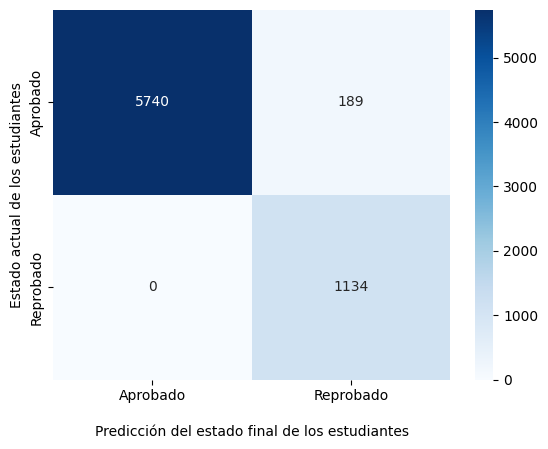

In [ ]:
cf_matrix = confusion_matrix(numeric_y_test_scaler, predictions)
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt='d')
ax.set_xlabel('\nPredicción del estado final de los estudiantes')
ax.set_ylabel('Estado actual de los estudiantes');
ax.xaxis.set_ticklabels(['Aprobado', 'Reprobado'])
ax.yaxis.set_ticklabels(['Aprobado', 'Reprobado'])
plt.show()

In [ ]:
from yellowbrick.classifier import ROCAUC

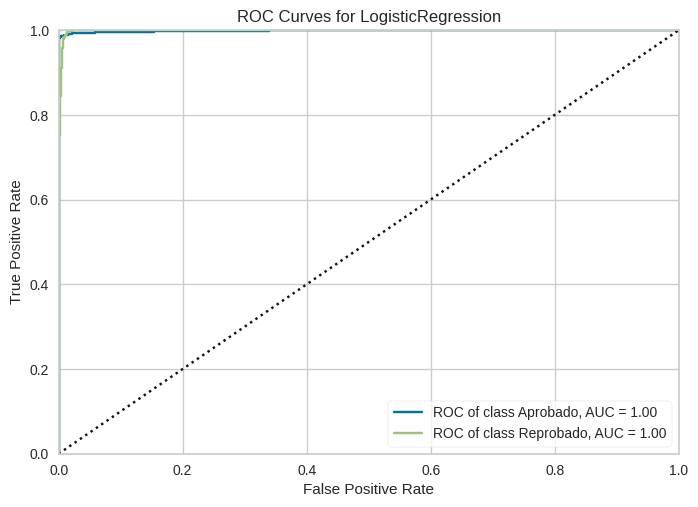

In [ ]:
visualizer = ROCAUC(
    logistic_regresion_model,
    macro = False,
    micro = False,
    encoder = {0: 'Aprobado', 1: 'Reprobado'},
)
visualizer.fit(numeric_x_train_scaler, numeric_y_train_scaler)
visualizer.score(numeric_x_train_scaler, numeric_y_train_scaler)
visualizer.finalize()

In [ ]:
auc_logistic_regression = visualizer

## **Modelo 3: Bosque aleatorio**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [ ]:
rand_forest_classifier_model = RandomForestClassifier(random_state = 0, max_depth = 5, class_weight = 'balanced')
rand_forest_classifier_model.fit(numeric_x_train_scaler, numeric_y_train)
predictions = rand_forest_classifier_model.predict(numeric_x_test_scaler)

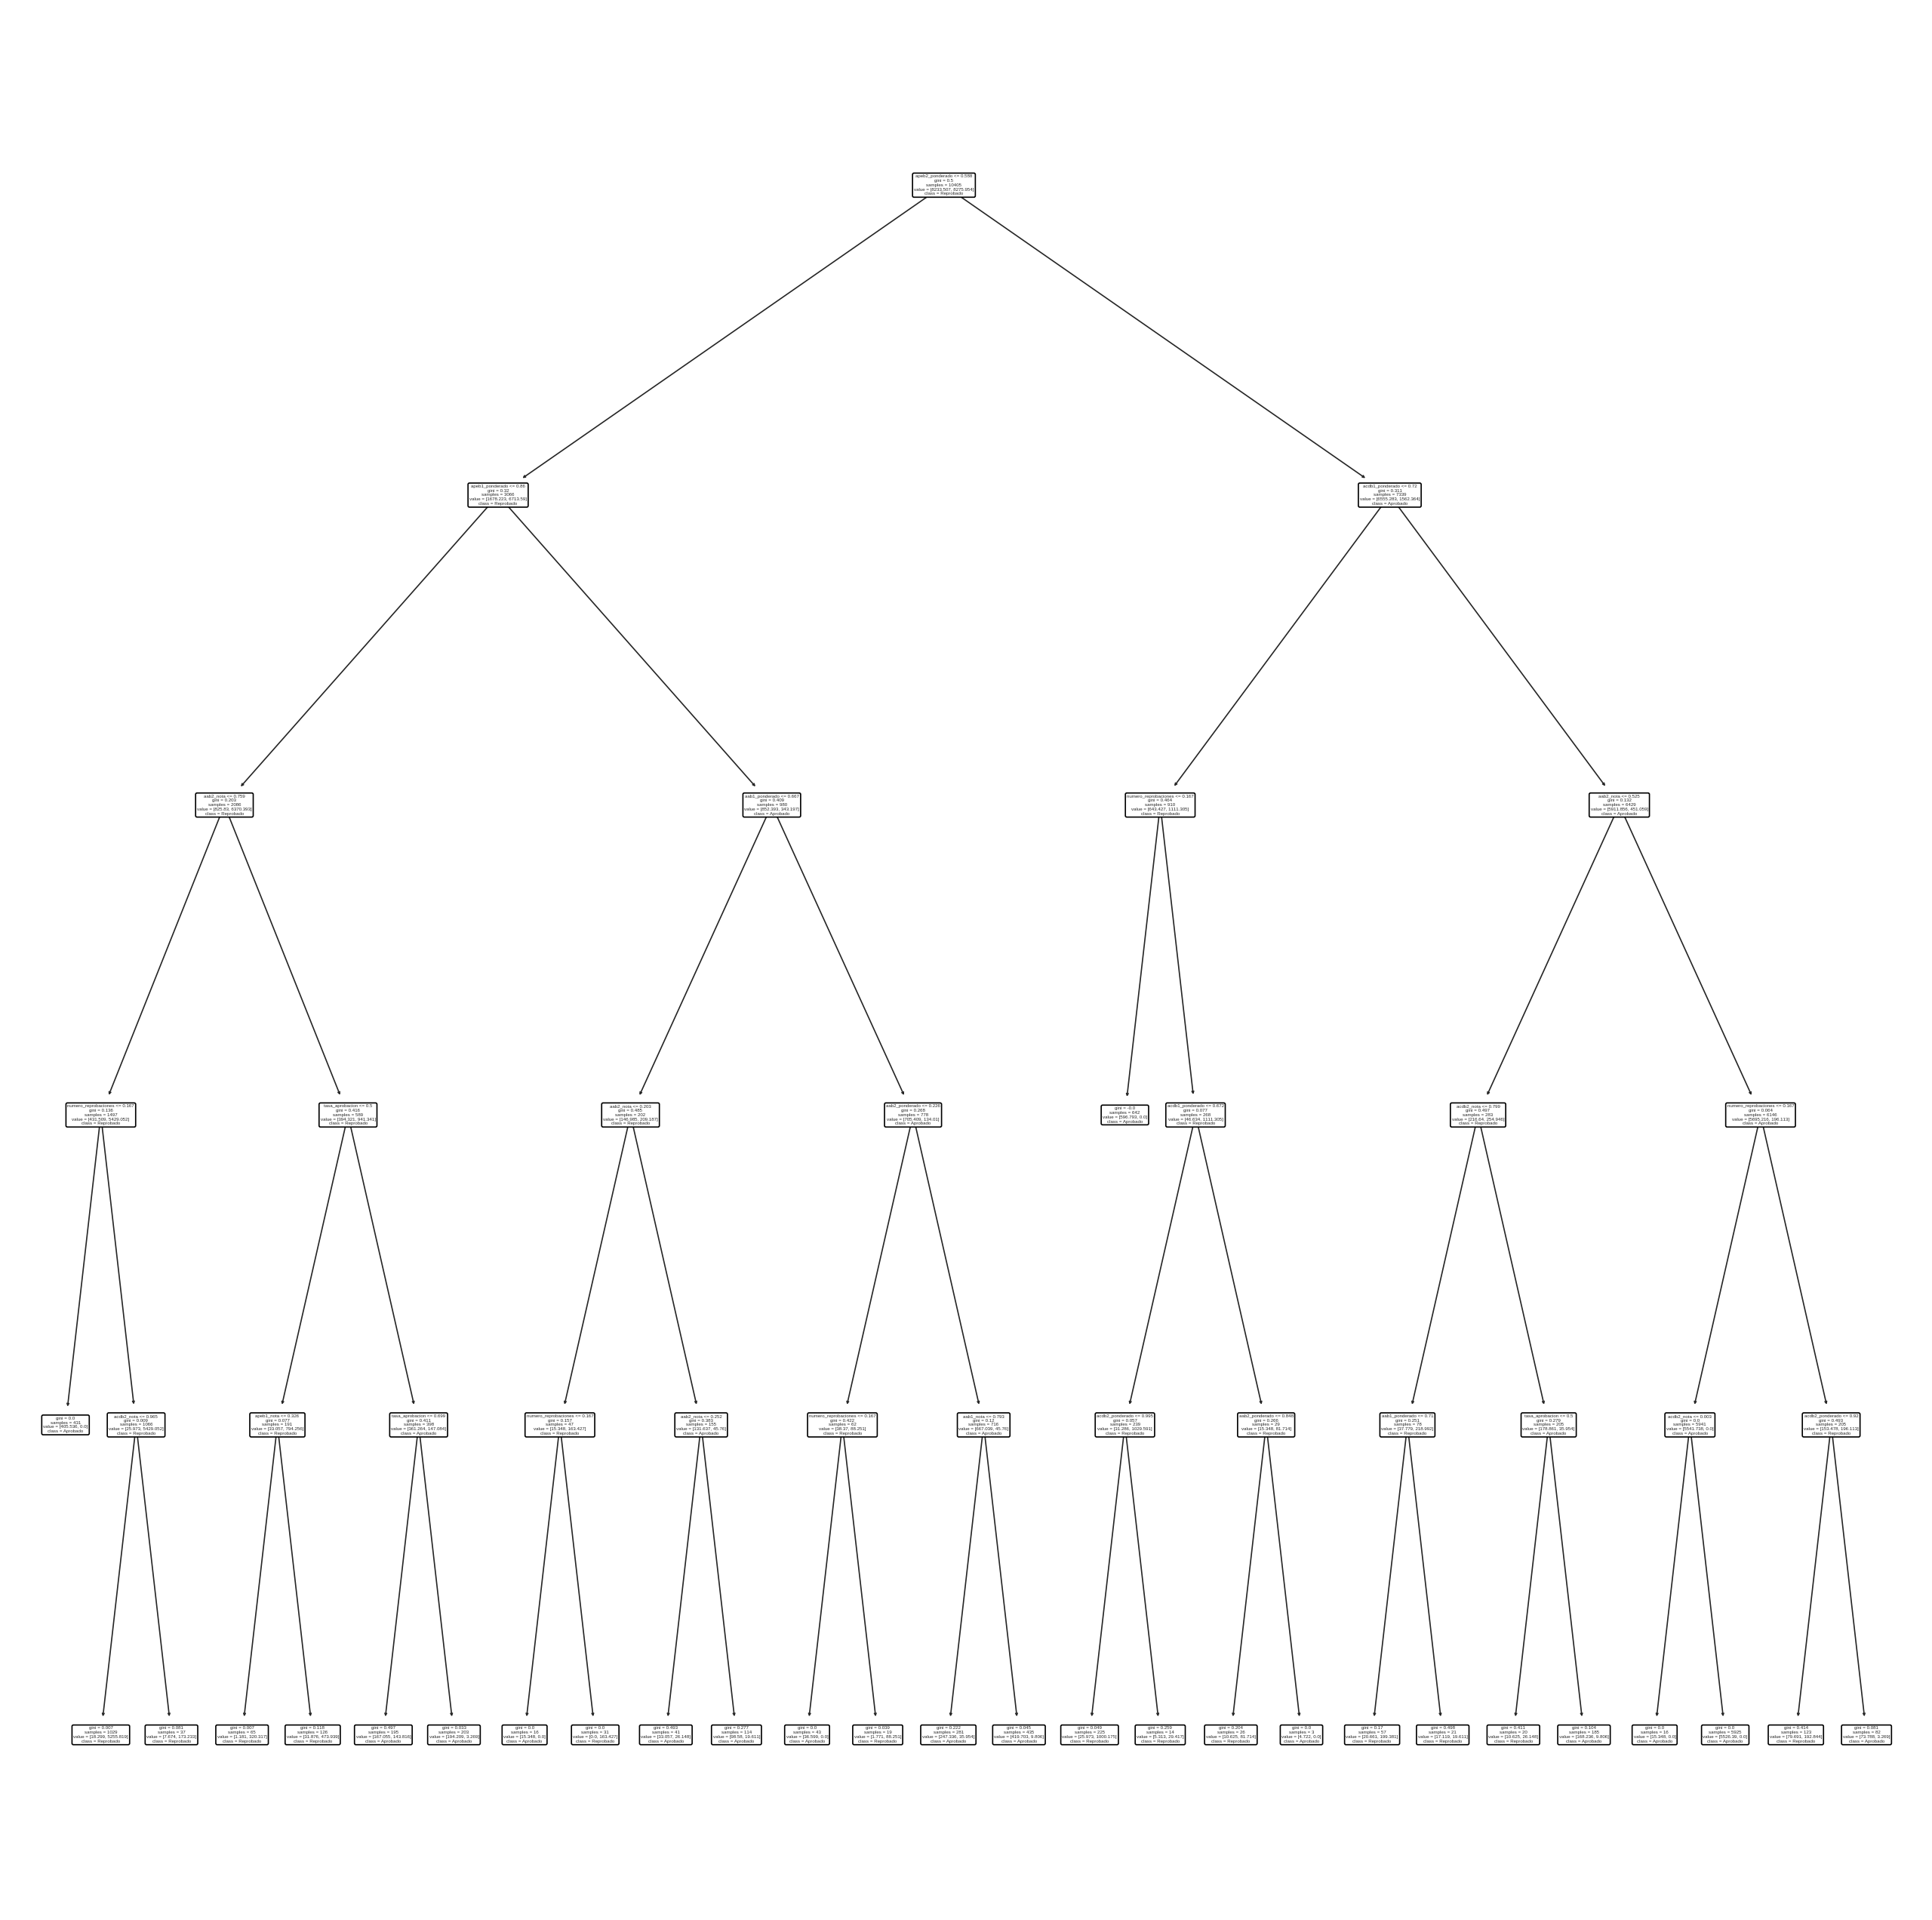

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1,figsize = (8,8), dpi = 400)
tree.plot_tree(
    rand_forest_classifier_model.estimators_[0],
    feature_names = numeric_x_train.columns,
    class_names = ['Aprobado', 'Reprobado'],
    rounded = True
)
fig.savefig('rf_individualtree1.png')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
accuracy = rand_forest_classifier_model.score(numeric_x_train_scaler, numeric_y_train_scaler)
print(f"Precisión del modelo: {accuracy}")

Precisión del modelo: 0.9889563106796116


In [ ]:
from sklearn import metrics

In [ ]:
print(classification_report(numeric_y_test_scaler, predictions, target_names = ['Aprobado', 'Reprobado']))

              precision    recall  f1-score   support

    Aprobado       1.00      0.99      0.99      5929
   Reprobado       0.94      1.00      0.97      1134

    accuracy                           0.99      7063
   macro avg       0.97      0.99      0.98      7063
weighted avg       0.99      0.99      0.99      7063



In [ ]:
mcm = multilabel_confusion_matrix(numeric_y_test_scaler, predictions)
true_negative = mcm[:, 0, 0]
false_positive = mcm[:, 0, 1]
specificiy = true_negative / (true_negative + false_positive)

In [ ]:
metrics = pd.DataFrame({
    'Especificidad': specificiy
}, index=['Aprobado', 'Reprobado'])
metrics

,Especificidad
Aprobado,0.997354
Reprobado,0.987688


In [ ]:
results = pd.DataFrame({
    'status': numeric_y_test.values,
    'status_predicted': predictions
}).replace([0, 1], ['Aprobado', 'Reprobado'])

results.head(10)

,status,status_predicted
0,Reprobado,Reprobado
1,Aprobado,Aprobado
2,Aprobado,Aprobado
3,Reprobado,Reprobado
4,Aprobado,Aprobado
5,Reprobado,Reprobado
6,Aprobado,Aprobado
7,Aprobado,Aprobado
8,Aprobado,Aprobado
9,Reprobado,Reprobado


In [ ]:
import plotly.graph_objects as go

In [ ]:
bar_chart = [
    go.Bar(
        name = 'Valores reales',
        x = ['Aprobado', 'Reprobado'],
        y = results['status'].value_counts()

    ),
    go.Bar(
        name = 'Valores predichos',
        x = ['Aprobado', 'Reprobado'],
        y = results['status_predicted'].value_counts()
    )
]

figure = {
    'data': bar_chart,
    'layout': {
        'xaxis': {
            'title': 'Estado final de los estudiantes',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'yaxis': {
            'title': 'Cantidad de datos',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'legend': {
            'x': 0.8, 'y': 1.0,
            'bgcolor': 'rgba(255, 255, 255, 0)',
            'bordercolor': 'rgba(255, 255, 255, 0)'
        },
        'paper_bgcolor': 'rgba(255, 255, 255, 0)',
        'barmode': 'group',
        'bargap': 0.15,
        'bargroupgap': 0.1
    }

}

go.Figure(figure).show()

In [ ]:
pd.concat([
    pd.DataFrame(results['status'].value_counts()),
    pd.DataFrame(results['status_predicted'].value_counts())
], axis=1)

,status,status_predicted
Aprobado,5929,5859
Reprobado,1134,1204


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

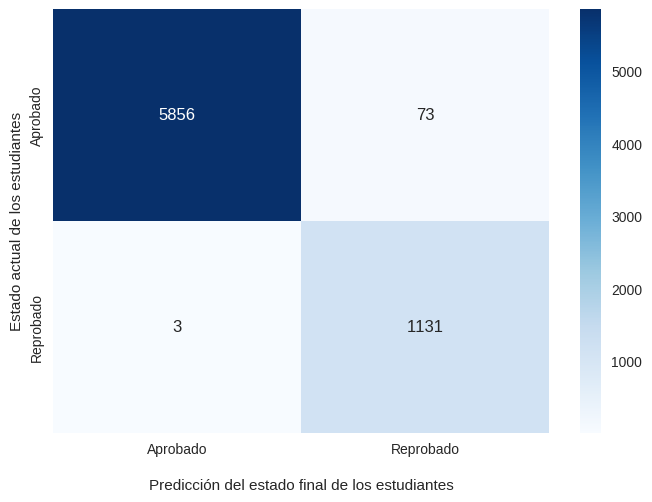

In [ ]:
cf_matrix = confusion_matrix(numeric_y_test_scaler, predictions)
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt='d')
ax.set_xlabel('\nPredicción del estado final de los estudiantes')
ax.set_ylabel('Estado actual de los estudiantes');
ax.xaxis.set_ticklabels(['Aprobado', 'Reprobado'])
ax.yaxis.set_ticklabels(['Aprobado', 'Reprobado'])
plt.show()

In [ ]:
from yellowbrick.classifier import ROCAUC

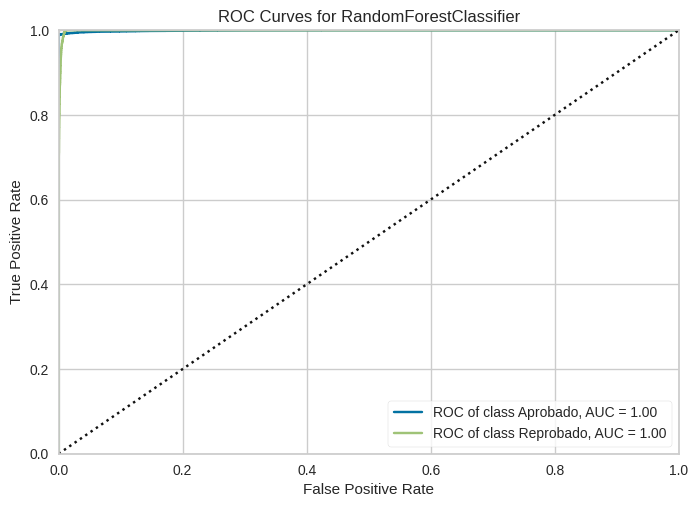

In [ ]:
visualizer = ROCAUC(
    rand_forest_classifier_model,
    macro = False,
    micro = False,
    encoder = {0: 'Aprobado', 1: 'Reprobado'},
)
visualizer.fit(numeric_x_train_scaler, numeric_y_train_scaler)
visualizer.score(numeric_x_train_scaler, numeric_y_train_scaler)
visualizer.finalize()

In [ ]:
auc_random_forest = visualizer

## **Modelo 4: Redes Neuronales de Clasificación**

In [ ]:
import numpy as np
import itertools
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.utils import class_weight

In [ ]:
numeric_y_train_array = np.asarray(list(numeric_y_train_scaler))
numeric_y_test_array = np.asarray(list(numeric_y_test_scaler))

In [ ]:
classes = np.unique(numeric_y_train_array)
class_weights = dict(zip(
    classes,
    class_weight.compute_class_weight(
        class_weight = 'balanced',
        classes = classes,
        y = numeric_y_train_array.ravel()
    )
))

In [ ]:
# !rm -rf logs/
# !rm -rf models/

In [ ]:
neural_network_model = Sequential([
    Dense(6, activation = 'relu'),
    Dropout(0.5),
    Dense(2, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

neural_network_model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

checkpoint_filepath = f'models/checkpoint-neural-network-model.hdf5'
model_chekpoint = ModelCheckpoint(
        filepath = checkpoint_filepath,
        monitor = 'accuracy',
        verbose = 0,
        save_best_only = True,
        mode ='auto',
        save_freq = 1,
        save_weights_only = True
    )

early_stop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1,
    patience = 25
)

log_dir = f'logs/fit/neural-network-model'
tensorboard = TensorBoard(log_dir = log_dir, histogram_freq = 1)

neural_network_model.fit(
    x = numeric_x_train,
    y = numeric_y_train_array,
    class_weight = class_weights,
    epochs = 2000,
    validation_data = [numeric_x_test_scaler, numeric_y_test_array],
    callbacks = [model_chekpoint, tensorboard, early_stop]
)

predictions = list(itertools.chain(*(neural_network_model.predict(numeric_x_test_scaler) > 0.5).astype('int32')))

Epoch 1/2000
515/515 [==============================] - 9s 11ms/step - loss: 2.0782 - accuracy: 0.3246 - val_loss: 0.7606 - val_accuracy: 0.1606
Epoch 2/2000
515/515 [==============================] - 4s 9ms/step - loss: 0.7227 - accuracy: 0.1674 - val_loss: 0.7335 - val_accuracy: 0.1606
Epoch 3/2000
515/515 [==============================] - 2s 3ms/step - loss: 0.6958 - accuracy: 0.1649 - val_loss: 0.7135 - val_accuracy: 0.1606
Epoch 4/2000
515/515 [==============================] - 2s 3ms/step - loss: 0.6964 - accuracy: 0.1608 - val_loss: 0.7022 - val_accuracy: 0.1637
Epoch 5/2000
515/515 [==============================] - 1s 3ms/step - loss: 0.6913 - accuracy: 0.1649 - val_loss: 0.6981 - val_accuracy: 0.1710
Epoch 6/2000
515/515 [==============================] - 2s 3ms/step - loss: 0.6897 - accuracy: 0.1639 - val_loss: 0.6966 - val_accuracy: 0.1740
Epoch 7/2000
515/515 [==============================] - 1s 3ms/step - loss: 0.6922 - accuracy: 0.3007 - val_loss: 0.6977 - val_accuracy

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
test_loss, test_accuracy = neural_network_model.evaluate(numeric_x_test_scaler, numeric_y_test_array, verbose = 2)
print(f'Precisión del modelo: {test_accuracy}')

221/221 - 0s - loss: 0.9767 - accuracy: 0.1606 - 265ms/epoch - 1ms/step
Precisión del modelo: 0.16055500507354736


In [ ]:
print(classification_report(numeric_y_test_array, predictions, target_names = ['Aprobado', 'Reprobado']))

              precision    recall  f1-score   support

    Aprobado       0.00      0.00      0.00      5929
   Reprobado       0.16      1.00      0.28      1134

    accuracy                           0.16      7063
   macro avg       0.08      0.50      0.14      7063
weighted avg       0.03      0.16      0.04      7063



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
mcm = multilabel_confusion_matrix(numeric_y_test_scaler, predictions)
true_negative = mcm[:, 0, 0]
false_positive = mcm[:, 0, 1]
specificiy = true_negative / (true_negative + false_positive)

In [ ]:
metrics = pd.DataFrame({
    'Especificidad': specificiy
}, index=['Aprobado', 'Reprobado'])
metrics

,Especificidad
Aprobado,1.0
Reprobado,0.0


In [ ]:
results = pd.DataFrame({
    'status': numeric_y_test.values,
    'status_predicted': predictions
}).replace([0, 1], ['Aprobado', 'Reprobado'])

results.head(10)

,status,status_predicted
0,Reprobado,Reprobado
1,Aprobado,Reprobado
2,Aprobado,Reprobado
3,Reprobado,Reprobado
4,Aprobado,Reprobado
5,Reprobado,Reprobado
6,Aprobado,Reprobado
7,Aprobado,Reprobado
8,Aprobado,Reprobado
9,Reprobado,Reprobado


In [ ]:
import plotly.graph_objects as go

In [ ]:
bar_chart = [
    go.Bar(
        name = 'Valores reales',
        x = ['Aprobado', 'Reprobado'],
        y = results['status'].value_counts()

    ),
    go.Bar(
        name = 'Valores predichos',
        x = ['Aprobado', 'Reprobado'],
        y = results['status_predicted'].value_counts()
    )
]

figure = {
    'data': bar_chart,
    'layout': {
        'xaxis': {
            'title': 'Estado final de los estudiantes',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'yaxis': {
            'title': 'Cantidad de datos',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'legend': {
            'x': 0.8, 'y': 1.0,
            'bgcolor': 'rgba(255, 255, 255, 0)',
            'bordercolor': 'rgba(255, 255, 255, 0)'
        },
        'paper_bgcolor': 'rgba(255, 255, 255, 0)',
        'barmode': 'group',
        'bargap': 0.15,
        'bargroupgap': 0.1
    }

}

go.Figure(figure).show()

In [ ]:
pd.concat([
    pd.DataFrame(results['status'].value_counts()),
    pd.DataFrame(results['status_predicted'].value_counts())
], axis=1)

,status,status_predicted
Aprobado,5929,NaN
Reprobado,1134,7063.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

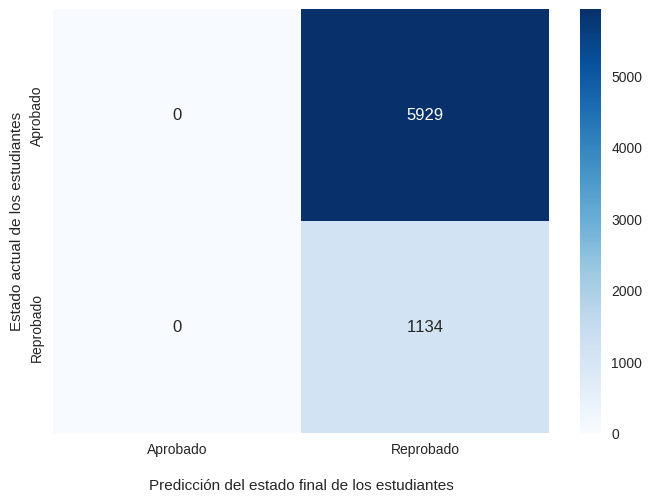

In [ ]:
cf_matrix = confusion_matrix(numeric_y_test_scaler, predictions)
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt='d')
ax.set_xlabel('\nPredicción del estado final de los estudiantes')
ax.set_ylabel('Estado actual de los estudiantes');
ax.xaxis.set_ticklabels(['Aprobado', 'Reprobado'])
ax.yaxis.set_ticklabels(['Aprobado', 'Reprobado'])
plt.show()

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_keras = neural_network_model.predict(numeric_x_test_scaler)
auc_neural_network_fpr = dict()
auc_neural_network_tpr = dict()
auc_neural_network_roc_auc = dict()
n_classes = 2

for i in range(n_classes):
    auc_neural_network_fpr[i], auc_neural_network_tpr[i], _ = roc_curve(numeric_y_test.ravel(), y_pred_keras.ravel())
    auc_neural_network_roc_auc[i] = auc(auc_neural_network_fpr[i], auc_neural_network_tpr[i])

221/221 [==============================] - 0s 1ms/step


## **Modelo 5: Redes Neuronales de Clasificación Recurrentes - LTSM**

In [ ]:
import numpy as np
import itertools
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.utils import class_weight

In [ ]:
numeric_y_train_array = np.asarray(list(numeric_y_train_scaler))
numeric_y_test_array = np.asarray(list(numeric_y_test_scaler))
numeric_x_train_3d = np.resize(numeric_x_train_scaler, (numeric_x_train_scaler.shape[0], 1, numeric_x_train_scaler.shape[1]))
numeric_x_test_3d = np.resize(numeric_x_test_scaler, (numeric_x_test_scaler.shape[0], 1, numeric_x_test_scaler.shape[1]))

In [ ]:
classes = np.unique(numeric_y_train_array)
class_weights = dict(zip(
    classes,
    class_weight.compute_class_weight(
        class_weight = 'balanced',
        classes = classes,
        y = numeric_y_train_array.ravel()
    )
))

In [ ]:
# !rm -rf logs/
# !rm -rf models/

In [ ]:
neural_network_recurreny_model = Sequential([
    Bidirectional(
        LSTM(
            20,
            dropout = 0.6
        )
    ),
    Dense(6, activation = 'relu'),
    Dropout(0.5),
    Dense(2, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

neural_network_recurreny_model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

checkpoint_filepath = f'models/recurrent/checkpoint-neural-network-model.hdf5'
model_chekpoint = ModelCheckpoint(
        filepath = checkpoint_filepath,
        monitor = 'accuracy',
        verbose = 0,
        save_best_only = True,
        mode ='auto',
        save_freq = 1,
        save_weights_only = True
    )

early_stop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1,
    patience = 25
)

log_dir = f'logs/recurrent/fit/neural-network-model'
tensorboard = TensorBoard(log_dir = log_dir, histogram_freq = 1)

neural_network_recurreny_model.fit(
    x = numeric_x_train_3d,
    y = numeric_y_train_array,
    class_weight = class_weights,
    epochs = 2000,
    validation_data = [numeric_x_test_3d, numeric_y_test_array],
    callbacks = [model_chekpoint, tensorboard, early_stop]
)

predictions = list(itertools.chain(*(neural_network_recurreny_model.predict(numeric_x_test_3d) > 0.5).astype('int32')))

Epoch 1/2000
515/515 [==============================] - 14s 15ms/step - loss: 0.5357 - accuracy: 0.7596 - val_loss: 0.2523 - val_accuracy: 0.8727
Epoch 2/2000
515/515 [==============================] - 4s 8ms/step - loss: 0.4043 - accuracy: 0.8515 - val_loss: 0.2598 - val_accuracy: 0.8890
Epoch 3/2000
515/515 [==============================] - 4s 8ms/step - loss: 0.3810 - accuracy: 0.8765 - val_loss: 0.3028 - val_accuracy: 0.9032
Epoch 4/2000
515/515 [==============================] - 3s 6ms/step - loss: 0.3685 - accuracy: 0.8851 - val_loss: 0.2358 - val_accuracy: 0.9289
Epoch 5/2000
515/515 [==============================] - 3s 5ms/step - loss: 0.3679 - accuracy: 0.8850 - val_loss: 0.2047 - val_accuracy: 0.9424
Epoch 6/2000
515/515 [==============================] - 3s 5ms/step - loss: 0.3541 - accuracy: 0.8890 - val_loss: 0.2983 - val_accuracy: 0.9043
Epoch 7/2000
515/515 [==============================] - 4s 7ms/step - loss: 0.3461 - accuracy: 0.8938 - val_loss: 0.2752 - val_accurac

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
test_loss, test_accuracy = neural_network_recurreny_model.evaluate(numeric_x_test_3d, numeric_y_test_array, verbose = 2)
print(f'Precisión del modelo: {test_accuracy}')

221/221 - 1s - loss: 2.7632 - accuracy: 0.1606 - 613ms/epoch - 3ms/step
Precisión del modelo: 0.16055500507354736


In [ ]:
print(classification_report(numeric_y_test_array, predictions, target_names = ['Aprobado', 'Reprobado']))

              precision    recall  f1-score   support

    Aprobado       0.00      0.00      0.00      5929
   Reprobado       0.16      1.00      0.28      1134

    accuracy                           0.16      7063
   macro avg       0.08      0.50      0.14      7063
weighted avg       0.03      0.16      0.04      7063



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
mcm = multilabel_confusion_matrix(numeric_y_test_scaler, predictions)
true_negative = mcm[:, 0, 0]
false_positive = mcm[:, 0, 1]
specificiy = true_negative / (true_negative + false_positive)

In [ ]:
metrics = pd.DataFrame({
    'Especificidad': specificiy
}, index=['Aprobado', 'Reprobado'])
metrics

,Especificidad
Aprobado,1.0
Reprobado,0.0


In [ ]:
results = pd.DataFrame({
    'status': numeric_y_test.values,
    'status_predicted': predictions
}).replace([0, 1], ['Aprobado', 'Reprobado'])

results.head(10)

,status,status_predicted
0,Reprobado,Reprobado
1,Aprobado,Reprobado
2,Aprobado,Reprobado
3,Reprobado,Reprobado
4,Aprobado,Reprobado
5,Reprobado,Reprobado
6,Aprobado,Reprobado
7,Aprobado,Reprobado
8,Aprobado,Reprobado
9,Reprobado,Reprobado


In [ ]:
import plotly.graph_objects as go

In [ ]:
bar_chart = [
    go.Bar(
        name = 'Valores reales',
        x = ['Aprobado', 'Reprobado'],
        y = results['status'].value_counts()

    ),
    go.Bar(
        name = 'Valores predichos',
        x = ['Aprobado', 'Reprobado'],
        y = results['status_predicted'].value_counts()
    )
]

figure = {
    'data': bar_chart,
    'layout': {
        'xaxis': {
            'title': 'Estado final de los estudiantes',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'yaxis': {
            'title': 'Cantidad de datos',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'legend': {
            'x': 0.8, 'y': 1.0,
            'bgcolor': 'rgba(255, 255, 255, 0)',
            'bordercolor': 'rgba(255, 255, 255, 0)'
        },
        'paper_bgcolor': 'rgba(255, 255, 255, 0)',
        'barmode': 'group',
        'bargap': 0.15,
        'bargroupgap': 0.1
    }

}

go.Figure(figure).show()

In [ ]:
pd.concat([
    pd.DataFrame(results['status'].value_counts()),
    pd.DataFrame(results['status_predicted'].value_counts())
], axis=1)

,status,status_predicted
Aprobado,5929,NaN
Reprobado,1134,7063.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

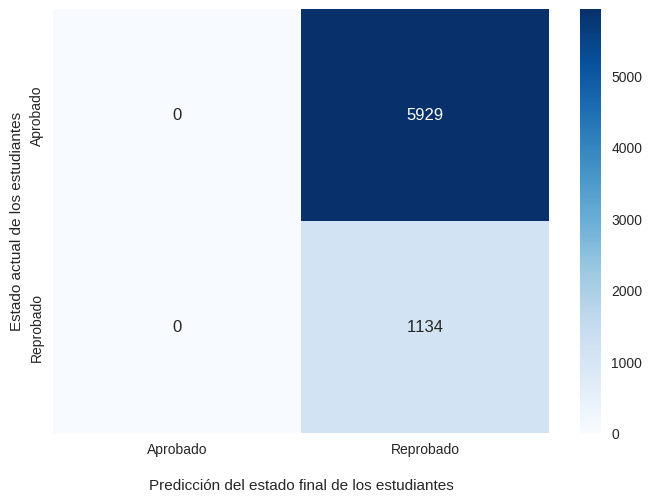

In [ ]:
cf_matrix = confusion_matrix(numeric_y_test_array, predictions)
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt='d')
ax.set_xlabel('\nPredicción del estado final de los estudiantes')
ax.set_ylabel('Estado actual de los estudiantes');
ax.xaxis.set_ticklabels(['Aprobado', 'Reprobado'])
ax.yaxis.set_ticklabels(['Aprobado', 'Reprobado'])
plt.show()

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_keras = neural_network_recurreny_model.predict(numeric_x_test_3d)
auc_neural_network_recurreny_fpr = dict()
auc_neural_network_recurreny_tpr = dict()
auc_neural_network_recurreny_roc_auc = dict()
n_classes = 2

for i in range(n_classes):
    auc_neural_network_recurreny_fpr[i], auc_neural_network_recurreny_tpr[i], _ = roc_curve(numeric_y_test_scaler.ravel(), y_pred_keras.ravel())
    auc_neural_network_recurreny_roc_auc[i] = auc(auc_neural_network_recurreny_fpr[i], auc_neural_network_recurreny_tpr[i])

221/221 [==============================] - 1s 2ms/step


# **Area bajo la curva**

In [ ]:
auc_graphs = [
    go.Scatter(
        showlegend=False,
        x = [0, 1],
        y = [0, 1],
        line={'color': '#000', 'dash': 'dash'},

    ),
    go.Scatter(
        name='Regresión Logística: Clase Aprobado, AUC = %.2f'%(auc_logistic_regression.roc_auc[0]),
        x = auc_logistic_regression.fpr[0],
        y = auc_logistic_regression.tpr[0],
        line = {'color':'#636EFA', 'dash': 'dash'}
    ),
    go.Scatter(
        name='Regresión Logística: Clase Reprobado, AUC = %.2f'%(auc_logistic_regression.roc_auc[1]),
        x = auc_logistic_regression.fpr[1],
        y = auc_logistic_regression.tpr[1],
        line = {'color':'#636EFA'}
    ),
    go.Scatter(
        name='Bosque Aleatorio: Clase Aprobado, AUC = %.2f'%(auc_random_forest.roc_auc[0]),
        x = auc_random_forest.fpr[0],
        y = auc_random_forest.tpr[0],
        line = {'color':'#109618', 'dash': 'dash'}
    ),
    go.Scatter(
        name='Bosque Aleatorio: Clase Reprobado, AUC = %.2f'%(auc_random_forest.roc_auc[1]),
        x = auc_random_forest.fpr[1],
        y = auc_random_forest.tpr[1],
        line = {'color':'#109618'}
    ),
    go.Scatter(
        name='Red Neuronal: Clase Aprobado, AUC = %.2f'%(auc_neural_network_roc_auc[0]),
        x = auc_neural_network_fpr[0],
        y = auc_neural_network_tpr[0],
        line = {'color':'#9467BD', 'dash': 'dash'}
    ),
    go.Scatter(
        name='Red Neuronal: Clase Reprobado, AUC = %.2f'%(auc_neural_network_roc_auc[1]),
        x = auc_neural_network_fpr[1],
        y = auc_neural_network_tpr[1],
        line = {'color':'#9467BD'}
    ),
    go.Scatter(
        name='Red Neuronal Recurrente: Clase Aprobado, AUC = %.2f'%(auc_neural_network_recurreny_roc_auc[0]),
        x = auc_neural_network_recurreny_fpr[0],
        y = auc_neural_network_recurreny_tpr[0],
        line = {'color':'#FFA15A', 'dash': 'dash'}
    ),
    go.Scatter(
        name='Red Neuronal Recurrente: Clase Reprobado, AUC = %.2f'%(auc_neural_network_recurreny_roc_auc[1]),
        x = auc_neural_network_recurreny_fpr[1],
        y = auc_neural_network_recurreny_tpr[1],
        line = {'color':'#FFA15A'}
    ),
]

figure = {
    'data': auc_graphs,
    'layout': {
        'title': 'Area bajo la curva',
        'legend': {
            'x': 0.7, 'y': 0,
            'bgcolor': 'rgba(255, 255, 255, 0)',
            'bordercolor': 'rgba(255, 255, 255, 0)'
        },
        'xaxis': {
            'title': 'Tasa de falsos positivos'
        },
        'yaxis': {
            'title': 'Tasa de verdaderos positivos'
        },
        'paper_bgcolor': 'rgba(255, 255, 255, 0)',
    }
}

go.Figure(figure).show()

# **Resumen de resultados**

| | Regresión Logística | Análisis Discriminante Lineal | Bosque aleatorio | Redes Neuronales de Clasificación | Redes Neuronales de Clasificación Recurrente |
|----------------------- | --------- | ----- | --------- | --------- | --------- |
| **Precisión**          | 0.930     | ----- | **0.970**     | 0.080     | 0.080 |
| **Sensibilidad**       | 0.985     | ----- | **0.995** | 0.500 | 0.500    |
| **Especificidad**      | 0.984     | ----- | **0.993** | 0.500     | 0.500     |
| **F-Score**            | 0.950     | ----- | **0.980** | 0.140 | 0.140    |
| **Area bajo la curva** | **1.000** | ----- | **1.000** | 0.510 | **1.000** |